In [1]:
import gymnasium as gym
import numpy as np
import d3rlpy
import pickle

import matplotlib.pyplot as plt
from env.atari.represented_atari_game import GymCompatWrapper2
from online_main import OneHotWrapper
from utils import get_llm_data_paths
from vis_utils import *

hyperparams = {
    "env": "CliffWalking-v0",  # CartPole-v0, Pendulum-v1, MountainCar-v0, FrozenLake-v1, CliffWalking-v0, RepresentedPong-v0
    "n_online_eps": 120,  # 10-5990 for mountainCar, 30-120 for CartPole
# hyperparams = {
#     "env": "FrozenLake-v1",  # CartPole-v0, Pendulum-v1, MountainCar-v0, FrozenLake-v1, CliffWalking-v0, RepresentedPong-v0
#     "n_online_eps": 120,  # 10-5990 for mountainCar, 30-120 for CartPole
    "n_pretrain_eps": 30,
    "seed": 42069,
    "max_episode_len": 200,  # Around 10h per 100k steps in Leviathan server
    "eps": 0.1,  # epsilon for exploration
    "n_exp": 5,
    "gpu": True,  # True if use GPU to train with d3rlpy
    "buffer_size": 100000,  # Test with 100k, 200k, 500k. 1M might be too much
    "data_path": None,  #'data/CartPole_Qwen2.5-7B-Instruct_Neps_10_20250406040150.pkl',
    "model_path": None,  #'d3rlpy_loss/DoubleDQN_online_20250331153346/model_600000.d3',
    "batch_size": 256,  # Test smaller batch size: 32, 64. May be noisier
    "learning_rate": 5e-5,
    "gamma": 0.99,
    "target_update_interval": 1000,  # Test with 1k, 2k, 5k
    "smooth": 10,  # For plotting, smooth the curve with this window size
    # "n_episodes": 150,
    "sft": False, # Set to True to use SFT data paths
    "long_cot": False, # Set to True to use DeepSeek long CoT data paths
    "awac": False,
}

hyperparams["n_episodes"] = hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]
# assert (
#     hyperparams["n_episodes"]
#     == hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]
# ), "Check n_episodes=n_pretrain_eps+n_online_eps"

if "Represented" in hyperparams["env"]:
    env = GymCompatWrapper2(gym.make(hyperparams["env"]))
    eval_env = GymCompatWrapper2(gym.make(hyperparams["env"]))
elif isinstance(gym.make(hyperparams["env"]).observation_space, gym.spaces.Discrete):
    env = OneHotWrapper(gym.make(hyperparams["env"]))
    eval_env = OneHotWrapper(gym.make(hyperparams["env"]))
else:
    env = gym.make(hyperparams["env"])
    eval_env = gym.make(hyperparams["env"])

# fix seed
d3rlpy.seed(hyperparams["seed"])
d3rlpy.envs.seed_env(env, hyperparams["seed"])
d3rlpy.envs.seed_env(eval_env, hyperparams["seed"])

2025-09-19 11:52.52 [info     ] Register Shimmy environments. 


/opt/miniconda3/envs/llamagym/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Static/pretrain data

In [2]:
path_7b, path_32b = get_llm_data_paths(hyperparams["env"], hyperparams["sft"], hyperparams["long_cot"])

with open(path_7b, "rb") as file:
    Qwen_7B_dataset = pickle.load(file)
with open(path_32b, "rb") as file:
    Qwen_32B_dataset = pickle.load(file)

Qwen_32B_rewards = []
for i in range(hyperparams["n_pretrain_eps"]):
    Qwen_32B_rewards.append(Qwen_32B_dataset.episodes[i].compute_return())
Qwen_7B_rewards = []
for i in range(hyperparams["n_pretrain_eps"]):
    Qwen_7B_rewards.append(Qwen_7B_dataset.episodes[i].compute_return())

Qwen_7B = hyperparams["n_episodes"] * [np.mean(Qwen_7B_rewards)]
Qwen_32B = hyperparams["n_episodes"] * [np.mean(Qwen_32B_rewards)]

print("Qwen_32B: ", np.mean(Qwen_7B_rewards))
print("Qwen_7B: ", np.mean(Qwen_32B_rewards))

Qwen_32B:  -509.6666666666667
Qwen_7B:  -7729.033333333334


In [3]:
try:
    env_name = hyperparams["env"].split("-")[0]
    if env_name == "Pendulum":
        path_SFT = f"data/{env_name}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250422210707SFT.pkl"
    elif env_name == "CliffWalking":
        path_SFT = f"data/{env_name}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250505135458SFT.pkl"
        # path_SFT = f"data/{env_name}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250421175530SFT.pkl" #CliffWalking typo
    elif env_name == "FrozenLake":
        path_SFT = f"data/{env_name}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250501013018SFT.pkl"
        # path_SFT = f"data/{env_name}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250421120400SFT.pkl" #FrozenLake typo

    with open(path_SFT, "rb") as file:
        Qwen_7B_SFT_dataset = pickle.load(file)

    Qwen_7B_SFT_rewards = []
    for i in range(hyperparams["n_pretrain_eps"]):
        Qwen_7B_SFT_rewards.append(Qwen_7B_SFT_dataset.episodes[i].compute_return())
    Qwen_7B_SFT = Qwen_7B_SFT_rewards + hyperparams["n_online_eps"] * [
        np.mean(Qwen_7B_SFT_rewards)
    ]
    print("Qwen_7B_SFT: ", np.mean(Qwen_7B_SFT_rewards))
except:
    Qwen_7B_SFT = None
try:
    path_DS_7B = f"data/{hyperparams['env'].split('-')[0]}_DeepSeek-R1-Distill-Qwen-7B_Neps_{hyperparams['n_pretrain_eps']}_20250502071148.pkl"  # FrozenLake
    path_DS_14B = f"data/{hyperparams['env'].split('-')[0]}_DeepSeek-R1-Distill-Qwen-14B_Neps_{hyperparams['n_pretrain_eps']}_20250502084016.pkl"  # FrozenLake
    # path_DS_7B = f"data/{hyperparams['env'].split('-')[0]}_DeepSeek-R1-Distill-Qwen-7B_Neps_{hyperparams['n_pretrain_eps']}_20250419172821.pkl" #FrozenLake typo
    # path_DS_14B = f"data/{hyperparams['env'].split('-')[0]}_DeepSeek-R1-Distill-Qwen-14B_Neps_{hyperparams['n_pretrain_eps']}_20250422000525.pkl" #FrozenLake typo
    with open(path_DS_7B, "rb") as file:
        DS_7B_dataset = pickle.load(file)
    with open(path_DS_14B, "rb") as file:
        DS_14B_dataset = pickle.load(file)
    DS_7B_rewards = []
    for i in range(hyperparams["n_pretrain_eps"]):
        DS_7B_rewards.append(DS_7B_dataset.episodes[i].compute_return())
    DS_14B_rewards = []
    for i in range(hyperparams["n_pretrain_eps"]):
        DS_14B_rewards.append(DS_14B_dataset.episodes[i].compute_return())

    DS_7B = hyperparams["n_episodes"] * [np.mean(DS_7B_rewards)]
    DS_14B = hyperparams["n_episodes"] * [np.mean(DS_14B_rewards)]
    # DS_7B = DS_7B_rewards + hyperparams["n_online_eps"] * [np.mean(DS_7B_rewards)]
    # DS_14B = DS_14B_rewards + hyperparams["n_online_eps"] * [np.mean(DS_14B_rewards)]

    print("DS_7B: ", np.mean(DS_7B_rewards))
    print("DS_14B: ", np.mean(DS_14B_rewards))
except:
    DS_7B = None
    DS_14B = None

Qwen_7B_SFT:  -394.7


### Generate and evaluate random baseline

In [4]:
# Evaluate the random policy manually
random_rewards = []
for _ in range(hyperparams["n_pretrain_eps"]):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    count = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward
        count += 1
        if count >= hyperparams["max_episode_len"]:
            break
    random_rewards.append(total_reward)

mean_random = np.ones(
    hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]
) * np.mean(random_rewards)
# Print the average reward of the random policy
print(f"Average reward for random policy: {mean_random[0]}")

Average reward for random policy: -2092.7


# Plot

In [5]:
all_cache = extract_data(hyperparams, Qwen_7B, Qwen_32B, DS_7B, DS_14B, mean_random, hyperparams["awac"])
# plot_main(hyperparams, all_cache, Qwen_7B, Qwen_32B, mean_random)
# plot_pretrain(hyperparams, all_cache)
# plot_mix(hyperparams, all_cache)
# plot_model_size(hyperparams, all_cache)
# plot_pretrain_step(hyperparams, all_cache)
# plot_pretrain_eps(hyperparams, all_cache)
# plot_sft_lcot(hyperparams, all_cache)
# # plot_pretrain_big(hyperparams, all_cache)
# # plot_sft_lcot_big(hyperparams, all_cache)

Environment is CliffWalking or FrozenLake. Extracting dataset for Transfer Coefficient calculation ...


## NOTE:
Need to re-run everything. Add AWAC, time clock, and an automatic script for everything

## Transfer Coefficient Upperbound (FrozenLake and CliffWalking only) (original and mixture of all steps)

In [12]:
n_online_eval_eps=10
merge_time_step=True #False to calculate the transfer coefficient in the original formula, True to merge the time step to compare coverage of the full sequence
def print_results(offline_dataset, online_dataset, n_pretrain_eps, n_online_eval_eps, text, merge_time_step=False):
    max_transfer_coef, max_key, (no_diff, no_online_keys, no_offline_keys, no_diff2) = datasets_to_transfer_coef_upper_bound(online_dataset, offline_dataset, n_pretrain_eps, n_online_eval_eps, merge_time_step=merge_time_step)
    if max_transfer_coef != np.inf:
        print(f"{text}: Max transfer coef: {max_transfer_coef} at step {max_key[0]}, state {max_key[1]}, action {max_key[2]}")
    else:
        print(f"{text}: Max transfer coef: inf")
    print(f"No of online keys: {no_online_keys}. No of offline keys: {no_offline_keys}. No online not offline: {no_diff}. No offline not online: {no_diff2}")
if hyperparams["env"] == "CliffWalking-v0" or hyperparams["env"] == "FrozenLake-v1":
    for i in range(hyperparams["n_exp"]):
        print(f"Experiment {i}:")
        for n_eps in [30]:
        # for n_eps in [10, 20, 30]:
            Qwen_7B_LORO_1000_Neps_dataset = all_cache[f"pretrain_7b_1000_{n_eps}_{i}_dataset"]
            Qwen_32B_LORO_1000_Neps_dataset = all_cache[f"pretrain_32b_1000_{n_eps}_{i}_dataset"]
            on_pol_1000_Neps_dataset = all_cache[f"on_pol_1000_{n_eps}_{i}_dataset"]
            on_pol_1000_Neps_offline_dataset = all_cache[f"on_pol_1000_{n_eps}_{i}_offline_dataset"]
            rand_1000_Neps_dataset = all_cache[f"rand_1000_{n_eps}_{i}_dataset"]
            rand_1000_Neps_offline_dataset = all_cache[f"rand_1000_{n_eps}_{i}_offline_dataset"]

            # print_results(Qwen_7B_dataset, Qwen_32B_dataset, hyperparams["n_pretrain_eps"], n_online_eval_eps, f"Qwen 7B vs Qwen 32B", merge_time_step)
            print_results(Qwen_7B_dataset, Qwen_7B_LORO_1000_Neps_dataset, hyperparams["n_pretrain_eps"], n_online_eval_eps, f"Qwen 7B LORO 1000 {n_eps}", merge_time_step)
            print_results(Qwen_32B_dataset, Qwen_32B_LORO_1000_Neps_dataset, hyperparams["n_pretrain_eps"], n_online_eval_eps, f"Qwen 32B LORO 1000 {n_eps}", merge_time_step)
            print_results(on_pol_1000_Neps_offline_dataset, on_pol_1000_Neps_dataset, hyperparams["n_pretrain_eps"], n_online_eval_eps, f"On-policy 1000 Neps {n_eps}", merge_time_step)
            print_results(rand_1000_Neps_offline_dataset, rand_1000_Neps_dataset, hyperparams["n_pretrain_eps"], n_online_eval_eps, f"Random 1000 Neps {n_eps}", merge_time_step)
        # print("--------------------------------")
    

Experiment 0:
Qwen 7B LORO 1000 30: Max transfer coef: 69.1025641025641 at step 0, state 47, action 2
No of online keys: 13. No of offline keys: 117. No online not offline: 0. No offline not online: 104
Qwen 32B LORO 1000 30: Max transfer coef: 5795.46 at step 0, state 0, action 0
No of online keys: 3. No of offline keys: 110. No online not offline: 0. No offline not online: 107
On-policy 1000 Neps 30: Max transfer coef: 4.077868852459017 at step 0, state 24, action 3
No of online keys: 2. No of offline keys: 48. No online not offline: 0. No offline not online: 46
Random 1000 Neps 30: Max transfer coef: inf
No of online keys: 1. No of offline keys: 4. No online not offline: 1. No offline not online: 4
Experiment 1:
Qwen 7B LORO 1000 30: Max transfer coef: 69.1025641025641 at step 0, state 47, action 2
No of online keys: 13. No of offline keys: 117. No online not offline: 0. No offline not online: 104
Qwen 32B LORO 1000 30: Max transfer coef: 150.1025641025641 at step 0, state 47, actio

## Plot the traces

In [7]:
if hyperparams["env"] == "CliffWalking-v0":
    width = 12
    height = 4
elif hyperparams["env"] == "FrozenLake-v1":
    width = 4
    height = 4
else:
    assert False, "Unsupported environment"

i=hyperparams["n_exp"]-1
n_eps=10
Qwen_7B_LORO_1000_Neps_dataset = all_cache[f"pretrain_7b_1000_{n_eps}_{i}_dataset"]
Qwen_32B_LORO_1000_Neps_dataset = all_cache[f"pretrain_32b_1000_{n_eps}_{i}_dataset"]
on_pol_1000_Neps_dataset = all_cache[f"on_pol_1000_{n_eps}_{i}_dataset"]
on_pol_1000_Neps_offline_dataset = all_cache[f"on_pol_1000_{n_eps}_{i}_offline_dataset"]
rand_1000_Neps_dataset = all_cache[f"rand_1000_{n_eps}_{i}_dataset"]
rand_1000_Neps_offline_dataset = all_cache[f"rand_1000_{n_eps}_{i}_offline_dataset"]

def plot_traces(offline_dataset, online_dataset, width, height, names, episode_indices=None, figsize=(8, 8), 
                        line_colors=["red", "green"], line_styles=None, alpha=0.2, 
                        show_grid=True, show_episode_numbers=True, title="Observation Traces",
                        linewidth=4, noise_std=0.075):
    fig, ax = plot_observation_traces(offline_dataset, width, height, episode_indices=episode_indices, figsize=figsize, 
                            line_colors=[line_colors[0]], line_styles=line_styles, alpha=alpha, 
                            show_grid=show_grid, show_episode_numbers=show_episode_numbers, title=title,
                            linewidth=linewidth, noise_std=noise_std, fig=None, ax=None, name=names[0])
    fig, ax = plot_observation_traces(online_dataset, width, height, episode_indices=episode_indices, figsize=figsize, 
                            line_colors=[line_colors[1]], line_styles=line_styles, alpha=alpha, 
                            show_grid=show_grid, show_episode_numbers=show_episode_numbers, title=title,
                            linewidth=linewidth, noise_std=noise_std, fig=fig, ax=ax, name=names[1], save_path=f'figs/{hyperparams["env"].split("-")[0]}_{names[0]}-{names[1]}_traces.pdf')


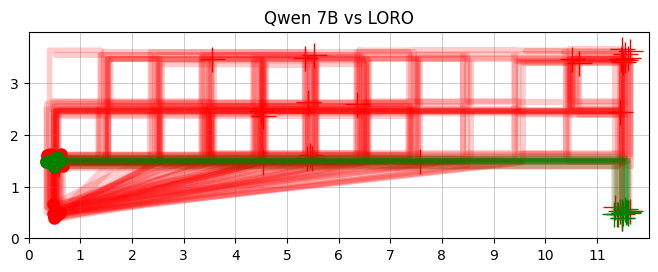

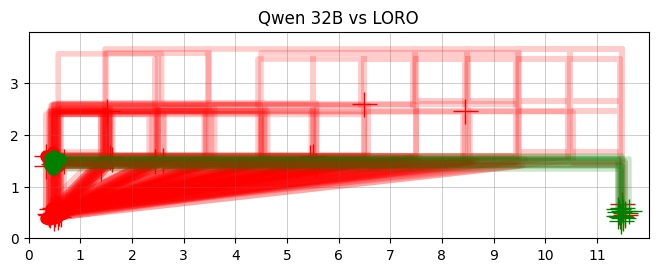

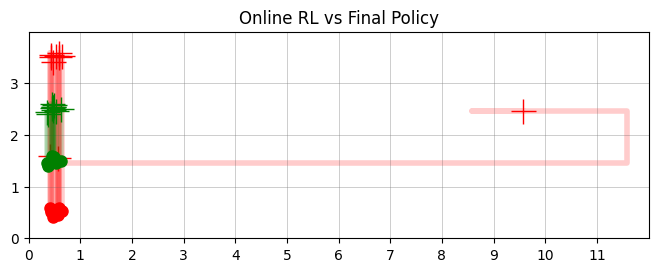

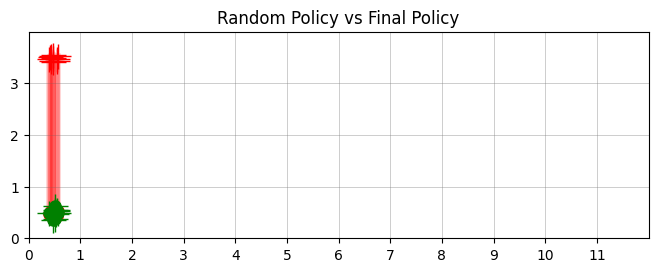

In [ ]:
plot_traces(Qwen_7B_dataset, Qwen_7B_LORO_1000_Neps_dataset, width, height, names=["Qwen 7B", "LLM-pretrain"], title="Qwen 7B vs LORO")
plot_traces(Qwen_32B_dataset, Qwen_32B_LORO_1000_Neps_dataset, width, height, names=["Qwen 32B", "LLM-pretrain"], title="Qwen 32B vs LORO")
plot_traces(on_pol_1000_Neps_offline_dataset, on_pol_1000_Neps_dataset, width, height, names=["Online RL", "Final Policy"], title="Online RL vs Final Policy")
plot_traces(rand_1000_Neps_offline_dataset, rand_1000_Neps_dataset, width, height, names=["Random Policy", "Final Policy"], title="Random Policy vs Final Policy")

## Plot distribution map for different steps

In [9]:
# for i in range(15):
#     plot_coverage_heatmap(Qwen_32B_dataset, hyperparams["n_pretrain_eps"], i, model_name="Qwen 32B", figsize=(10, 8), cmap='Blues', annot=True, fmt='.4f')


## Plot distribution map of the mixture of all steps

Total visits: 5390
Normalized coverage (first 5 entries): {(36, 1): 0.00575139146567718, (24, 0): 0.018738404452690167, (36, 2): 0.014100185528756958, (25, 1): 0.013543599257884972, (26, 1): 0.01261595547309833}


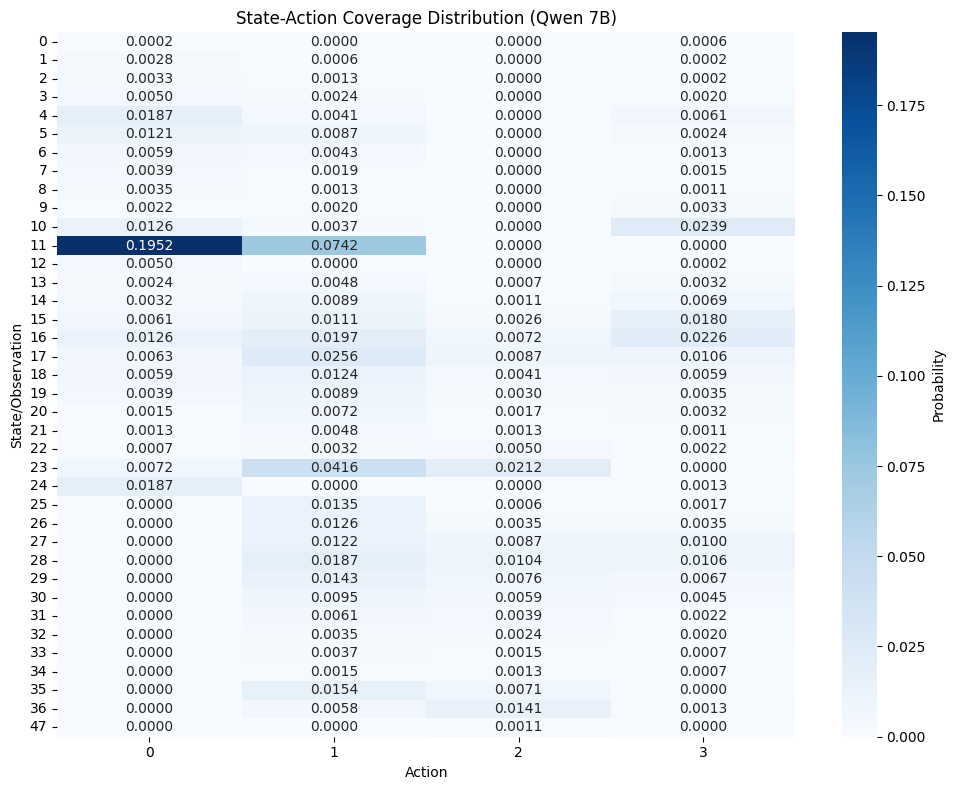

Number of unique state-action pairs: 117
Number of unique states: 38
Number of unique actions: 4
Maximum probability: 0.1952
Minimum probability: 0.0002
--------------------------------
Total visits: 5854
Normalized coverage (first 5 entries): {(36, 1): 0.26785104202254867, (24, 0): 0.12999658353262727, (12, 0): 0.00717458148274684, (13, 1): 0.006662111376836351, (14, 1): 0.004441407584557568}


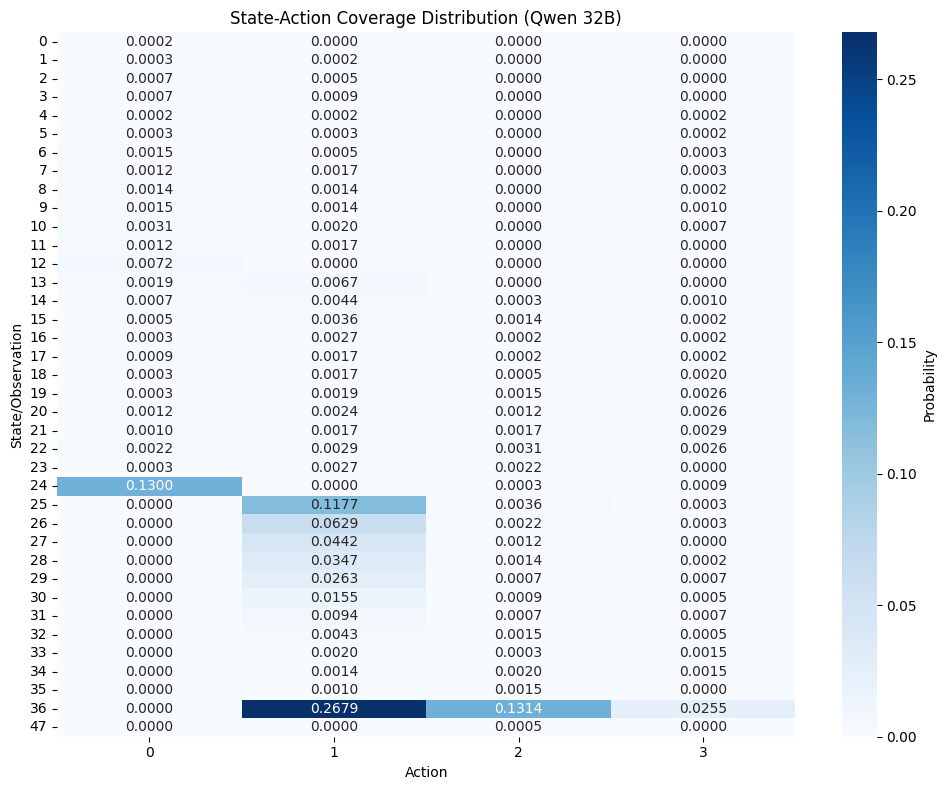

Number of unique state-action pairs: 110
Number of unique states: 38
Number of unique actions: 4
Maximum probability: 0.2679
Minimum probability: 0.0002
--------------------------------
Total visits: 130
Normalized coverage (first 5 entries): {(24, 0): 0.07692307692307693, (25, 1): 0.07692307692307693, (26, 1): 0.07692307692307693, (27, 1): 0.07692307692307693, (28, 1): 0.07692307692307693}


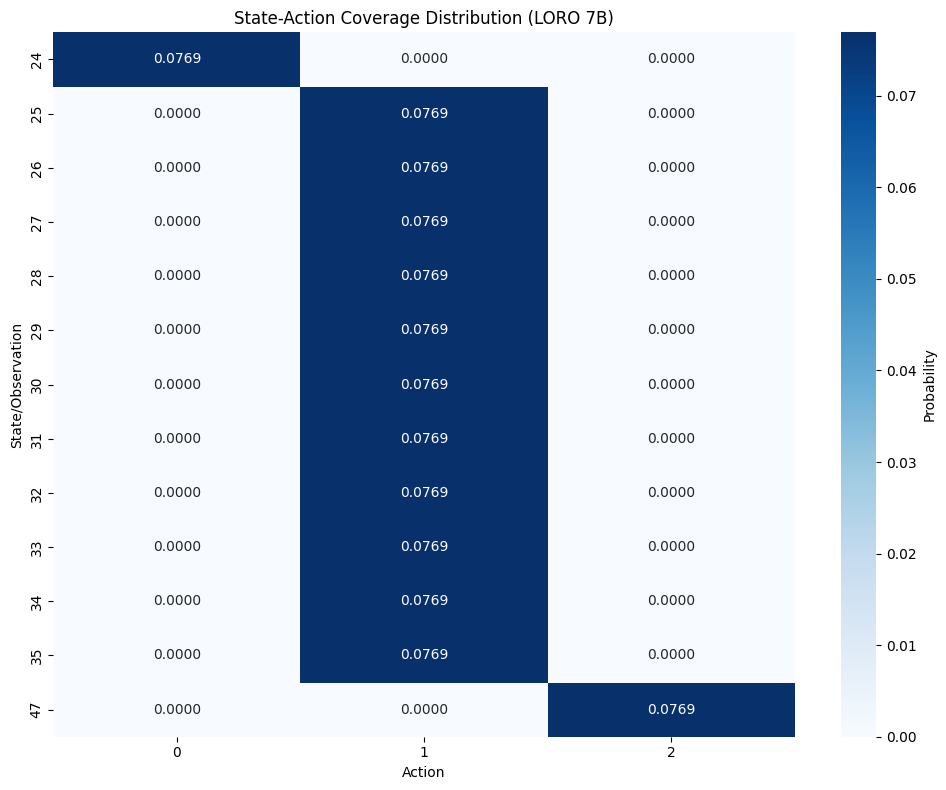

Number of unique state-action pairs: 13
Number of unique states: 13
Number of unique actions: 3
Maximum probability: 0.0769
Minimum probability: 0.0769
--------------------------------
Total visits: 130
Normalized coverage (first 5 entries): {(24, 0): 0.07692307692307693, (25, 1): 0.07692307692307693, (26, 1): 0.07692307692307693, (27, 1): 0.07692307692307693, (28, 1): 0.07692307692307693}


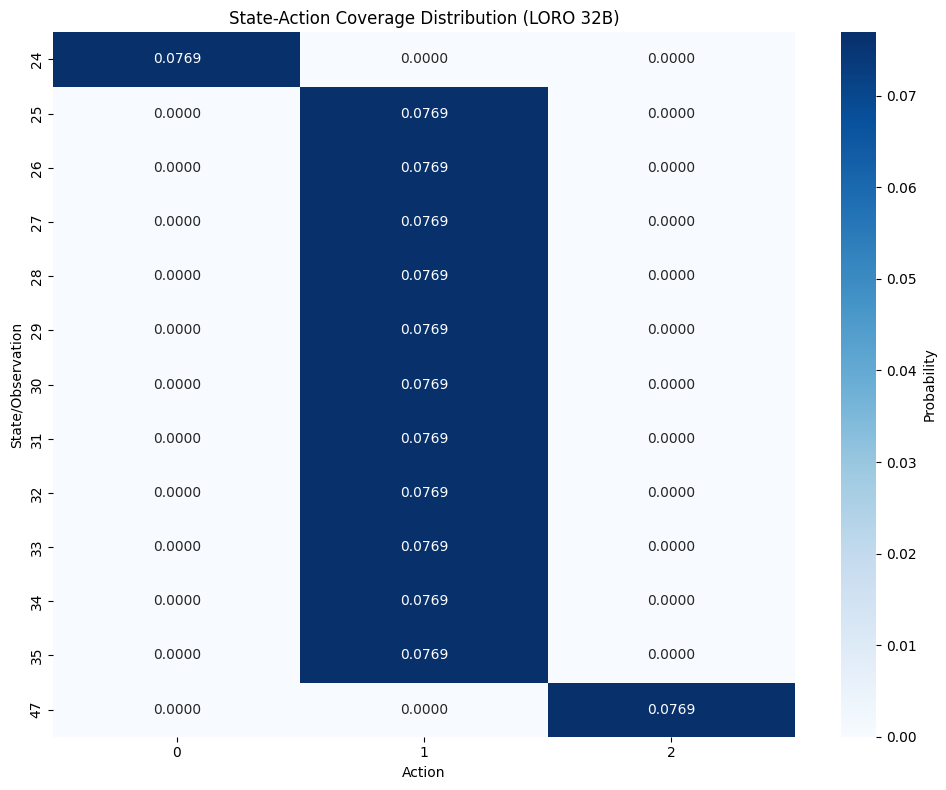

Number of unique state-action pairs: 13
Number of unique states: 13
Number of unique actions: 3
Maximum probability: 0.0769
Minimum probability: 0.0769
--------------------------------
Total visits: 6000
Normalized coverage (first 5 entries): {(36, 2): 0.03333333333333333, (36, 3): 0.035833333333333335, (36, 1): 0.006333333333333333, (36, 0): 0.012666666666666666, (24, 0): 0.071}


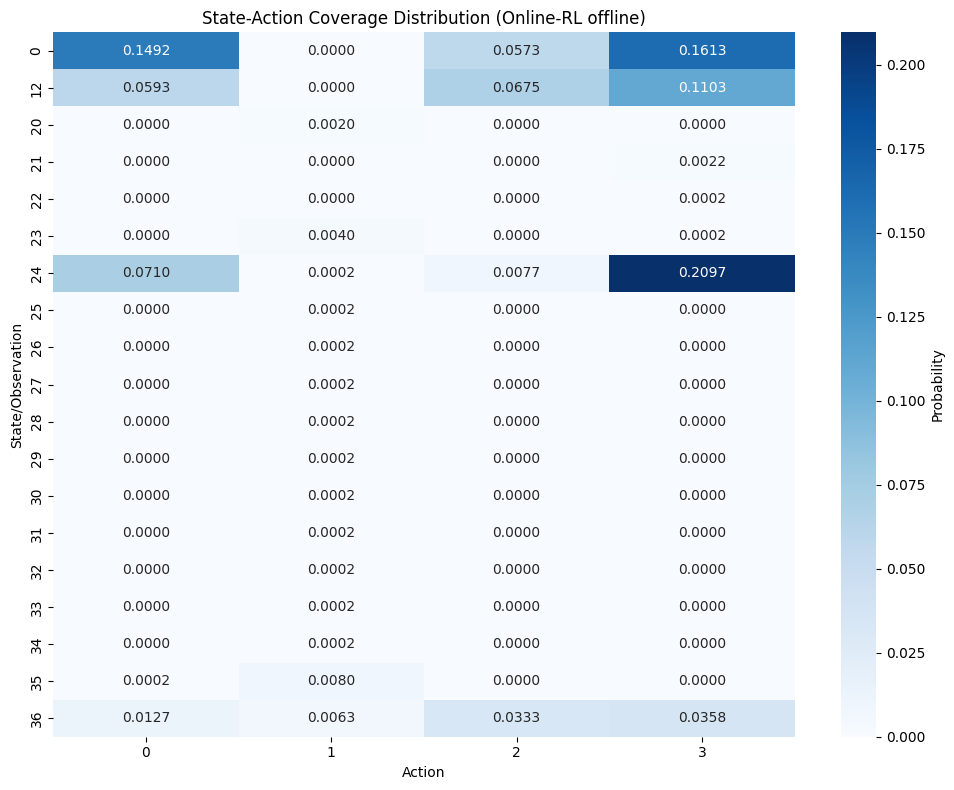

Number of unique state-action pairs: 31
Number of unique states: 19
Number of unique actions: 4
Maximum probability: 0.2097
Minimum probability: 0.0002
--------------------------------
Total visits: 2000
Normalized coverage (first 5 entries): {(36, 2): 1.0}


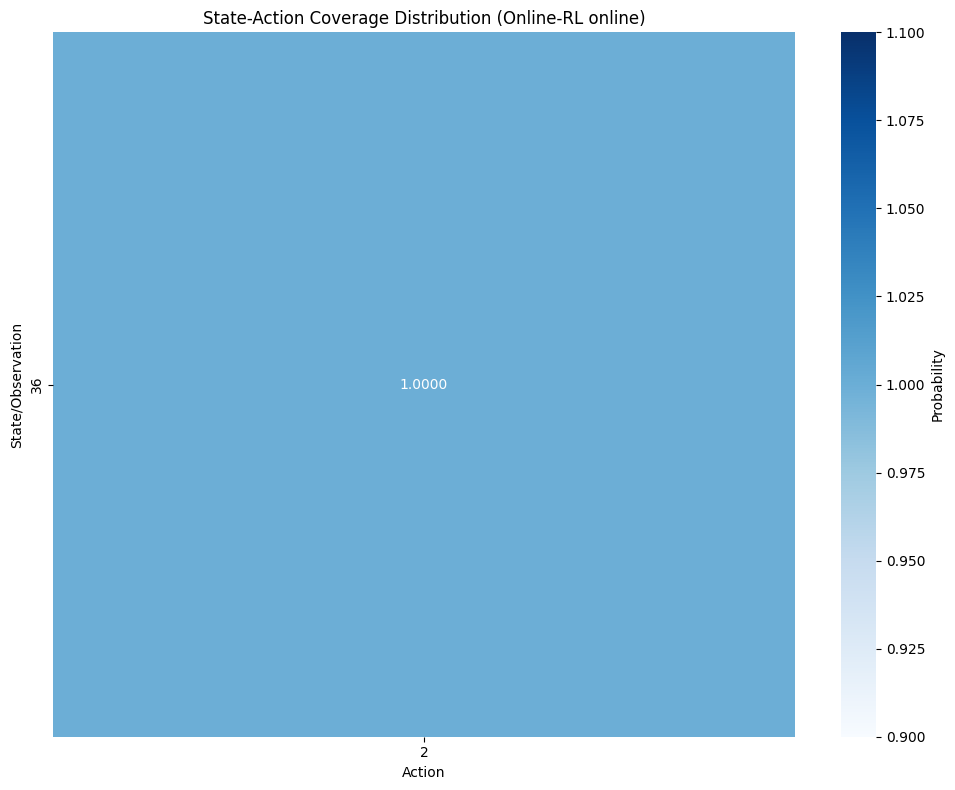

Number of unique state-action pairs: 1
Number of unique states: 1
Number of unique actions: 1
Maximum probability: 1.0000
Minimum probability: 1.0000
--------------------------------
Total visits: 6000
Normalized coverage (first 5 entries): {(36, 0): 0.005, (24, 0): 0.005, (12, 0): 0.005, (0, 0): 0.985}


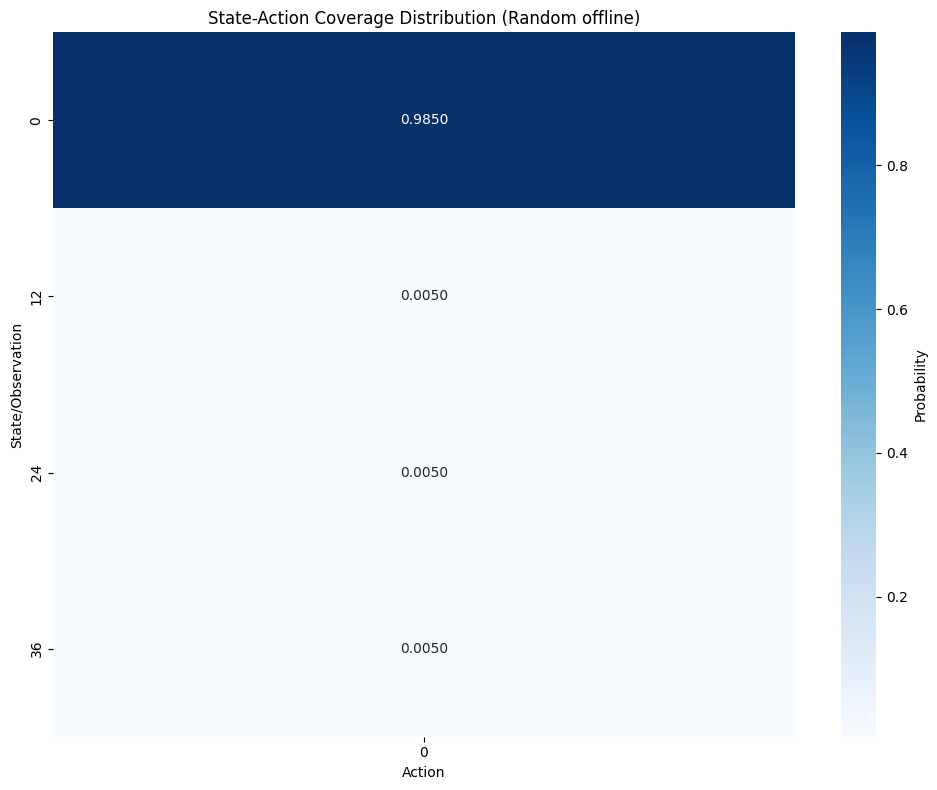

Number of unique state-action pairs: 4
Number of unique states: 4
Number of unique actions: 1
Maximum probability: 0.9850
Minimum probability: 0.0050
--------------------------------
Total visits: 2000
Normalized coverage (first 5 entries): {(24, 0): 0.005, (12, 0): 0.005, (0, 0): 0.99}


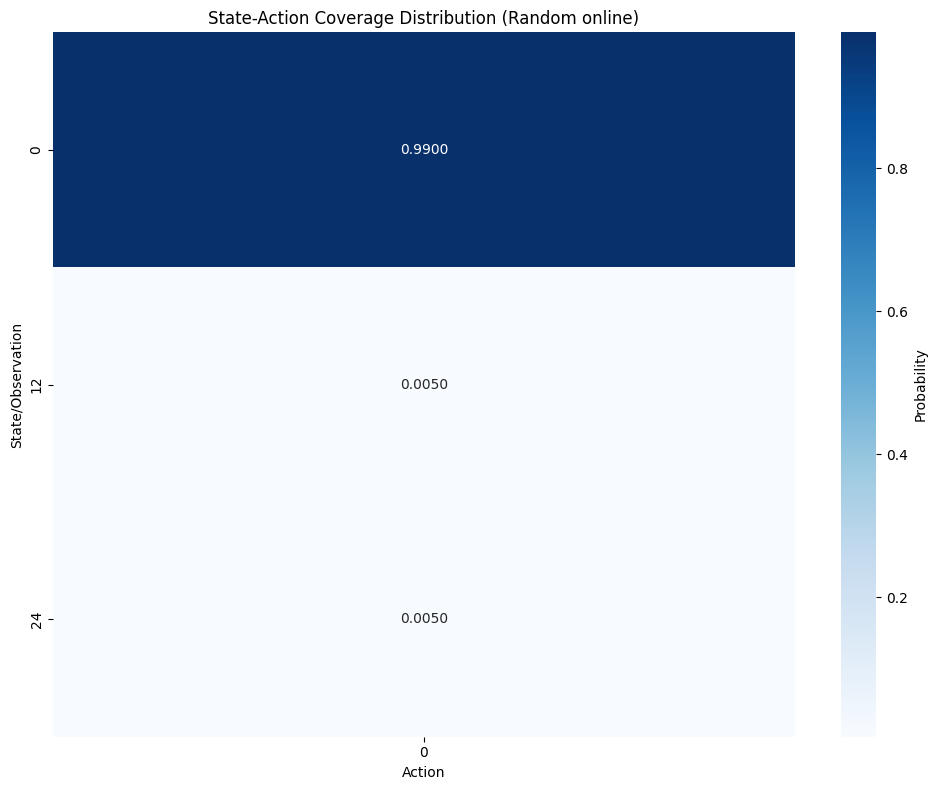

Number of unique state-action pairs: 3
Number of unique states: 3
Number of unique actions: 1
Maximum probability: 0.9900
Minimum probability: 0.0050
--------------------------------


In [ ]:
n_eps=30
hyperparams["n_pretrain_eps"]=n_eps
Qwen_7B_LORO_1000_Neps_dataset = all_cache[f"pretrain_7b_1000_{n_eps}_{i}_dataset"]
Qwen_32B_LORO_1000_Neps_dataset = all_cache[f"pretrain_32b_1000_{n_eps}_{i}_dataset"]
on_pol_1000_Neps_dataset = all_cache[f"on_pol_1000_{n_eps}_{i}_dataset"]
on_pol_1000_Neps_offline_dataset = all_cache[f"on_pol_1000_{n_eps}_{i}_offline_dataset"]
rand_1000_Neps_dataset = all_cache[f"rand_1000_{n_eps}_{i}_dataset"]
rand_1000_Neps_offline_dataset = all_cache[f"rand_1000_{n_eps}_{i}_offline_dataset"]


plot_coverage_heatmap(Qwen_7B_dataset, h=None, model_name="Qwen 7B")
plot_coverage_heatmap(Qwen_32B_dataset, h=None, model_name="Qwen 32B")
plot_coverage_heatmap(Qwen_7B_LORO_1000_Neps_dataset, h=None, model_name="LLM-pretrain 7B")
plot_coverage_heatmap(Qwen_32B_LORO_1000_Neps_dataset, h=None, model_name="LLM-pretrain 32B")
plot_coverage_heatmap(on_pol_1000_Neps_offline_dataset, h=None, model_name="Online-RL offline")
plot_coverage_heatmap(on_pol_1000_Neps_dataset, h=None, model_name="Online-RL online")
plot_coverage_heatmap(rand_1000_Neps_offline_dataset, h=None, model_name="Random offline")
plot_coverage_heatmap(rand_1000_Neps_dataset, h=None, model_name="Random online")
pass

## Create legends

In [ ]:
# # Updated legend creation with new function signature
# from vis_utils import create_legend_rectangle
# import matplotlib.pyplot as plt

# # Example 1: Qwen 7B vs LORO
# def create_legends(x_names, y_names):
#     for x_name, y_name in zip(x_names, y_names):
#         legend_fig, legend_ax = create_legend_rectangle(
#             x_name=x_name, 
#             y_name=y_name, 
#             figsize=(24, 1), fontsize=30, marker_sizes=30, text_offset=0.015,
#             save_path=f'figs/{x_name}_vs_{y_name}_legend.pdf'
#         )
#     plt.show()  # Display the legend

# x_names = ["Qwen 7B", "Qwen 32B", "Online RL", "Random policy"]
# y_names = ["LLM-pretrain", "LLM-pretrain", "Final Policy", "Final Policy"]
# create_legends(x_names, y_names)
